# ETAPE I : Chargement des données, des librairies et autres dépendances 

In [284]:
import os
import cv2
import glob
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation 
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras import backend as k
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import argparse
import imutils


In [186]:
chemin = "D:/ESIS/MASTER 2/Machine Learning/Projet Classification/Deep Learning pour la classification des images/Images"

In [187]:
print (os.listdir(chemin))

['test', 'train', 'val']


In [188]:
data_dir = Path(chemin)
train_dir = data_dir/'train'
val_dir = data_dir/'val'
test_dir = data_dir/'test'

In [189]:
def chargement_donnees():
    dir_felix = train_dir/'felix'
    dir_joseph = train_dir/'joseph'

    felix = dir_felix.glob('*.jpg')
    joseph = dir_joseph.glob('*.jpg')
    
    train_data = []
    train_label = []
    
    for img in felix :
        train_data.append(img)
        train_label.append('FELIX')
    
    for img in joseph :
        train_data.append(img)
        train_label.append('JOSEPH')
        
    df =pd.DataFrame(train_data)
    df.columns=['images']
    df['labels'] = train_label
    df = df.sample(frac=1).reset_index(drop=True)
    
    return df

In [190]:
train_data = chargement_donnees()
train_data.shape

(2088, 2)

# Voyons maintenant la distribution des étiquettes

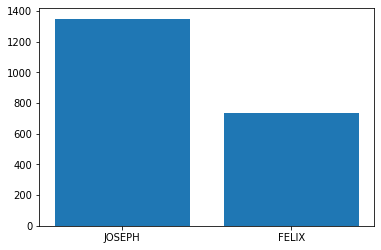

In [191]:
plt.bar(train_data['labels'].value_counts().index, train_data['labels'].value_counts().values)
plt.show()

### Visualisons certaines de nos images et voyons à quoi elles ressemblent  réellement.

In [192]:
def plot(image_batch, label_batch):
    plt.figure(figsize=(10,5))
    
    for i in range(10) :
        ax  = plt.subplot(2,5,i+1)
        
        try:
            img = cv2.imread(str(image_batch[i]))
            img = cv2.resize(img,(224,224))
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            plt.imshow(img)
            plt.title(label_batch[i])
            plt.axis("off")
        
        except Exception as e:
            print(str(e))

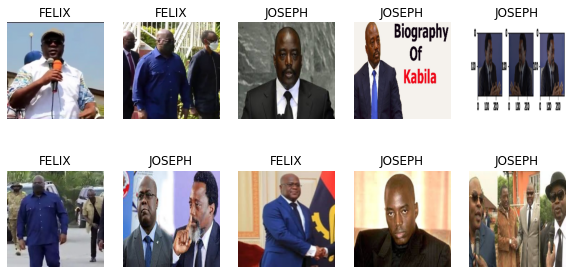

In [193]:
plot(train_data['images'], train_data['labels'])

# ETAPE II : Prétraitement des données

### Les différentes étapes de prétraitement que nous allons utiliser ici sont les suivantes :

1) Puisque les images sont de différentes longueurs et largeurs, nous allons les redimensionnez  à 224,224,3.

2) Certaines images sont en gris (1 canal), nous allons donc les convertir en 3 canaux.

3) Les images lues avec cv2 sont au format BGR (par défaut), nous allons les convertir en RGB.

4) Ensuite nous allons proceder par la division des  pixels de l'image par 255 (une astuce mathématique essentielle pour de meilleures performances)

In [196]:
def pre_preparation(v = True) :
    if v == True :
        dir_felix = val_dir/'felix'
        dir_joseph = val_dir/'joseph'
    else:
        dir_felix = test_dir/'felix'
        dir_joseph = test_dir/'joseph'
        
    felix = dir_felix.glob('*.jpg')
    joseph = dir_joseph.glob('*.jpg')

    data , labels = ([] for x in range (2))

    def prepare(case):  
        for img in case:
            img = cv2.imread(str(img))
            img = cv2.resize(img,(224,224))
            
            if img.shape[2] == 1 :
                img  = np.dstack([img,img,img])
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32) / 255
            
            if case == felix:
                label = to_categorical(0,num_classes = 2)
            elif case == joseph:
                label = to_categorical(1, num_classes=2)
            data.append(img)
            labels.append(label)
        return data, labels
    
    prepare(joseph)
    d,l = prepare(felix)
    d = np.array(d)
    l=np.array(l)
    return d,l


In [197]:
val_data, val_label = pre_preparation(v=True)
test_data, test_labels = pre_preparation(v=False)

print('Nombre des images de test --->> ',len(test_data))
print("Nombre des images de validation --->>", len(val_data))

Nombre des images de test --->>  512
Nombre des images de validation --->> 20


### Nous allons maintenant écrire une fonction pour générer des images par lots à partir des données d'entrainement.

In [212]:
def data_gen(data, batch_size):
    n = len(data)
    
    steps = n//batch_size
    
    
    batch_data = np.zeros((batch_size, 224,224, 3), dtype = np.float32)
    batch_labels = np.zeros((batch_size,2), dtype = np.float32)
    
    indices = np.arange(n)
    
    i = 0
    
    while True :
        np.random.shuffle(indices)
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch) :
            img_name  = data.iloc[idx]['images']
            label = data.iloc[idx]['labels']
            
            if label == 'FELIX' :
                label = 0
            elif label == 'JOSEPH' :
                label = 1
            
            encoded_label = to_categorical(label, num_classes = 2)
            img = cv2.imread(str(img_name))
            img = cv2.resize(img,(224,224))
            
            if(img.shape[2] == 1) :
                img = np.dstack([img,img,img])
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            orig_img = img.astype(np.float32) / 255
            
            batch_data[count] = orig_img
            batch_labels[count] = encoded_label
            
            count += 1
            
            if count == batch_size -1:
                break
        i+=1
        yield batch_data, batch_labels
        
        if i>= steps :
            i=0

In [225]:
batch_size = 16
nb_epochs = 5

train_data_gen = data_gen(data= train_data, batch_size = batch_size)

In [226]:
nb_train_steps = train_data.shape[0]//batch_size

'batch_size' fait référence au nombre d'images fournies au réseau en un seul passage

In [227]:
print("Nombre d'etape d'entrainement et de validation des données {} et {}".format(nb_train_steps, len(val_data)))

Nombre d'etape d'entrainement et de validation des données 130 et 20


# ETAPE 4 : Construire une image CNN

### Modèle Python de classification à partir de zéro

In [228]:
model = Sequential()

In [229]:
model.add(Conv2D(32,(3,3), input_shape = (224,224,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

In [230]:
model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

In [231]:
model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

In [232]:
model.add(Flatten())

In [233]:
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax'))

In [234]:
model.compile(optimizer= 'rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy'],)

On va utiliser la une fonction callback appelée EarlyStopping pour arrêter l'entraînement lorsque la val_loss baisse s'arrête.

In [235]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]



Lancement de l'entrainement de notre modèle 

In [236]:
history = model.fit(train_data_gen,   epochs = nb_epochs,
                    steps_per_epoch  = nb_train_steps,
                    validation_data = (val_data , val_label),
                    callbacks=my_callbacks
                   )

Epoch 1/6
130/130 [==============================] - 58s 426ms/step - loss: 0.5251 - accuracy: 0.7101 - val_loss: 1.0012 - val_accuracy: 0.5500
Epoch 2/6
130/130 [==============================] - 55s 424ms/step - loss: 0.3642 - accuracy: 0.8072 - val_loss: 0.6421 - val_accuracy: 0.6500
Epoch 3/6
130/130 [==============================] - 54s 419ms/step - loss: 0.3100 - accuracy: 0.8298 - val_loss: 0.9807 - val_accuracy: 0.5500
Epoch 4/6
130/130 [==============================] - 55s 424ms/step - loss: 0.2332 - accuracy: 0.8760 - val_loss: 0.7337 - val_accuracy: 0.6500


## Interpretation des resultats de notre modèle 

Il est tout à fait évident que la précision de notre validation n'est pas si bonne.

val_accurancy = 0.65 mais avec une perte enorme de 0.7

Il existe un certain nombre d'astuces que nous pouvons utiliser pour obtenir de bonnes performances. Entre autre : 

* Modifier la taille du lot. (chercher la bonne taille)
* Réajuster le nombre d'epoque pendant l'entrainement.
* Chercher un autre optimiseur. 
* Modifier le réseau neuronal en ajoutant/supprimant des couches.
* Augmenter la taille de notre Dataset

Apres plusieurs  essais (de la 1ere à la 3eme) techniques sans trouver un bon resultat, nous avons opté pour une autre alternative, l'utilisation de l'apprentissage par transfert

# ETAPE IV  : Apprentissage par transfert

L'apprentissage par transfert est une technique qui consiste à utiliser des réseaux neuronaux pré-formés sur des milliards d'images (comme Alexnet, Inception net, VGG16) pour une tâche différente en modifiant la dernière couche de classification.

Pour notre cas, nous allons utiliser le VGG16 pré-entraîné et nous ajouterons notre propre couche de classification (Dense) en bas, puis nous figerons le réseau jusqu'à l'avant-dernier bloc convolutif, puis nous le réentraînerons.

In [237]:
def vgg16_model(num_classes = None):
    model = VGG16(weights='imagenet', include_top = True, input_shape=(224,224,3))
    x = Dense(1024, activation ='relu')(model.layers[-4].output)
    x = Dropout(0.7)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(2,activation = 'softmax')(x)
    model=Model(model.input, x)
    
    return model


In [238]:
vgg_conv = vgg16_model(2)

for layer in vgg_conv.layers[:-10]:
    layer.trainable =  False
opt = Adam(learning_rate=0.0001, decay = 1e-5)
vgg_conv.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=opt)

Lancement de l'entrainement du modèle optenu par transfert

In [239]:
history = vgg_conv.fit(train_data_gen,   epochs = nb_epochs,
                    steps_per_epoch  = nb_train_steps,
                    validation_data = (val_data , val_label),
                    callbacks=my_callbacks,
                    class_weight={0:1.0,1:0.4}
                   )

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/6
130/130 [==============================] - 1069s 8s/step - loss: 0.3075 - accuracy: 0.7135 - val_loss: 0.1705 - val_accuracy: 0.9500
Epoch 2/6
130/130 [==============================] - 1103s 8s/step - loss: 0.1170 - accuracy: 0.8904 - val_loss: 0.0289 - val_accuracy: 1.0000
Epoch 3/6
130/130 [==============================] - 1090s 8s/step - loss: 0.1015 - accuracy: 0.8995 - val_loss: 0.1231 - val_accuracy: 0.9500
Epoch 4/6
130/130 [==============================] - 1109s 9s/step - loss: 0.0557 - accuracy: 0.9351 - val_loss: 0.0155 - val_accuracy: 1.0000
Epoch 5/6
130/130 [==============================] - 1034s 8s/step - loss: 0.0256 - accuracy: 0.9606 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 6/6
130/130 [==============================] - 1049s 8s/step - loss: 0.0200 - accuracy: 0.9635 - val_loss: 0.0590 - val_accuracy: 0.9500


 # ETAPE V  :  Évaluation des performances de notre modèle

## Performances de notre modèle sur les données de test. 

In [242]:
perte, precision  = vgg_conv.evaluate(test_data, test_labels, batch_size = 20)
print("Perte : {} et precision : {} ".format(perte, precision))

26/26 [==============================] - 211s 8s/step - loss: 0.3053 - accuracy: 0.9277
Perte : 0.3053446412086487 et precision : 0.927734375 


Avec la precision de 0.92, notre modèle est capable de donner un bon resultat dans 92 % des cas, ce qui est une bonne chose. Par contre, le niveau d'erreur etant de 30%, ceci n'est pas un tres bon resultat

## Rapport de classification

In [243]:
pred = vgg_conv.predict(test_data, batch_size=20)
pred = np.argmax(pred, axis = -1)

In [244]:
labels = np.argmax(test_labels, axis = -1)

print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       0.95      0.88      0.91       224
           1       0.91      0.97      0.94       288

    accuracy                           0.93       512
   macro avg       0.93      0.92      0.93       512
weighted avg       0.93      0.93      0.93       512



### Interpretation

La precision : 

* Dans 95 % des cas, les photos de Felix sont classées en tant que Felix
* Dans 91 % des cas, les photos de Joseph sont classées en tant que Joseph

Potentialité : 

* Notre model a le potentiel de 88 % a reconnaitre Felix
* Et le potentiel de 97 % a reconnaitre Joseph


## Matrice de confusion

<AxesSubplot:>

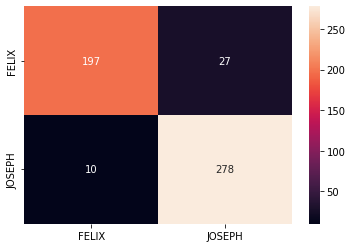

In [246]:
cm  = confusion_matrix(labels, pred)
sns.heatmap(cm, annot=True, fmt='g', xticklabels =['FELIX','JOSEPH'], yticklabels = ['FELIX','JOSEPH'])

Explication de la matrice de confusion :

* 197 images de Felix sont predites comme Felix
* 10 images de felix sont classé en tant que Joseph
* 278 images de Joseph sont predites comme Joseph
* Et 27 images de Joseph sont prédites comme Felix

## ETAPE VI : Enregistrement du model




In [254]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
activation_45 (Activation)   (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 109, 109, 32)      9248      
_________________________________________________________________
activation_46 (Activation)   (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 52, 52, 32)       

In [274]:
chemin = 'D:/ESIS/MASTER 2/Machine Learning/Projet Classification/Deep Learning pour la classification des images/model'
model.save(chemin)

INFO:tensorflow:Assets written to: D:/ESIS/MASTER 2/Machine Learning/Projet Classification/Deep Learning pour la classification des images/model\assets


# PREDICTION D'UNE NOUVELLE IMAGE

Deux possibilités pour faire la prediction
1. Predidre un ficheir stocké sur le disque local (chemin absolu du fichier)
2. Predire un fichier en ligne (lien hypertexte du fichier)

## Utilisation du model

In [294]:
def predire (mon_model, img):
    
    # load the image
    image = cv2.imread(chemin_image)
    orig = image.copy()
    image = cv2.resize(image, (224, 224))
    image = image.astype("float") / 255
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    
  

    print("Prediction .... .")
   
    # classify the input image
    (Felix, Joseph) = mon_model.predict(image)[0]

    # build the label
    label = "Felix" if Felix > Joseph else "Joseph"
    proba = Felix if Felix > Joseph else Joseph
    label = "{}: {:.2f}%".format(label, proba * 100)

    print(label)
    
    plt.figure()
    
    try:
        img = cv2.imread(chemin_image)
        img = cv2.resize(img,(224,224))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(label)
        plt.axis("off")

    except Exception as e:
        print(str(e))
        
    # draw the label on the image
    output = imutils.resize(orig, width=400)
    cv2.putText(output, label, (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,
        0.7, (0, 255, 0), 2)
    # show the output image
    cv2.imshow("Output", output)
    cv2.waitKey(0)



Prediction .... .
Felix: 98.44%


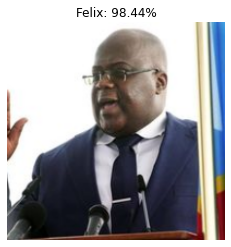

In [293]:
mon_model = load_model(chemin, compile = True)
chemin_image = "D:/ESIS/MASTER 2/Machine Learning/Projet Classification/Deep Learning pour la classification des images/Images/Prediction/2.jpg"
predire(mon_model,chemin)